In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import copy
from collections import Iterable
import json

from keras import Model, Input, Sequential, regularizers, losses, optimizers, regularizers, initializers
from keras.layers import Activation, Dense, LSTM, Embedding, Dropout, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, minmax_scale, StandardScaler, scale
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression, Lasso
from sklearn.feature_selection import f_regression, mutual_info_regression
from tsfresh.feature_selection.relevance import calculate_relevance_table
import boruta

%matplotlib inline

/opt/miniconda3/envs/research_trash/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/miniconda3/envs/research_trash/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/opt/miniconda3/envs/research_trash/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
plt.style.use(plt.style.library['dark_background'])
plt.rcParams['grid.color'] = '#333333'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

In [26]:
class SelectModel():
    def __init__(self, model, threshold=1e-5, max_features=None):
        self.model = model
        self.threshold = threshold
        self.max_features = max_features
    
    def fit(self, X, y):
        self.model.fit(X,y)
        scores = abs(self.model.coef_)
        
        f = scores
        f = f/f.sum()
        self.ranks_ = pd.Series(f, index=X.columns, name='ranks')
        
        ranks_sort = self.ranks_.sort_values(ascending=False) 
        
        scores = pd.Series(scores, X.columns)
        selected_features_ = scores[scores>1e-5].index
        
        if self.max_features is None:
            self.max_features = X.shape[1]
            
        if len(selected_features_) > self.max_features:
            selected_features_ = ranks_sort.iloc[:self.max_features].index
        
        self.selected_features_ = np.array(selected_features_)
            
        return self

In [27]:
class SelectTsfresh():
    def __init__(self, fdr_level=0.05):
        self.fdr_level = fdr_level
    
    def fit(self, X, y):
        relevance = calculate_relevance_table(X, y, fdr_level=self.fdr_level)
        relevance = relevance.reindex(X.columns)
        
        f = relevance['p_value'].dropna()
        f = 1-f
        f = f/f.sum()
        relevance['ranks'] = f
        relevance['ranks'].fillna(0, inplace=True)
        self.ranks_ = relevance['ranks']
        
        self.selected_features_ = relevance[relevance['relevant']==True]['feature'].values
        
        return self

In [28]:
class SelectFunction():
    def __init__(self, function, volume_info=0.97, max_features=None):
        self.function = function
        self.volume_info = volume_info
        self.max_features = max_features
    
    def fit(self, X, y):
        scores = self.function(X,y)
        if isinstance(scores, tuple):
            scores = scores[0]
        
        f = np.nan_to_num(scores)
        f = f/f.sum()
        self.ranks_ = pd.Series(f, index=X.columns, name='ranks')
        
        ranks_sort = self.ranks_.sort_values(ascending=False) 

        for i in ranks_sort.index:
            summ = ranks_sort[:i].sum()
            if summ > self.volume_info:
                break
        selected_features_ = ranks_sort[:i].index
        
        if self.max_features is None:
            self.max_features = X.shape[1]
            
        if len(selected_features_) > self.max_features:
            selected_features_ = ranks_sort.iloc[:self.max_features].index
        
        self.selected_features_ = np.array(selected_features_)
            
        return self

In [29]:
class SelectBoruta():
    def __init__(self, boruta, only_confirmed=True, prefit=False):
        self.prefit = prefit
        self.core = boruta
        self.only_confirmed = only_confirmed
    
    def fit(self, X, y):
        if not self.prefit:
            self.core.fit(np.array(X), np.array(y))
        
        f = self.core.ranking_
        f = f.sum()/f
        f = f/f.sum()
        
        self.ranks_ = pd.Series(f, index=X.columns, name='ranks')
        
        if self.only_confirmed:
            z = zip(X.columns, self.core.support_, np.zeros(X.shape[1]))
        else:
            z = zip(X.columns, self.core.support_, self.core.support_weak_)
            
        selected_features_ = []
        for i in z:
            if i[1] or i[2]:
                selected_features_.append(i[0])
        
        self.selected_features_ = np.array(selected_features_)
            
        return self

In [7]:
def mass_fit(X, y, models, metric=mean_squared_error, seed=None, verbose=True):
    if not isinstance(models, Iterable):
        models = (models,)
    
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.25, shuffle=False)
    
    if verbose:
        print(f'train on {len(trainY)}, test on {len(testY)} rows x {len(trainX.columns)} columns')
    
    total = []

    for model in models:
        if seed is not None:
            np.random.seed(seed)
        
        cls = model.__class__
        
        model.fit(trainX, trainY)
        preds = model.predict(testX)
    
        result = metric(testY, preds)
        
        if verbose:
            print(f'{cls.__name__:21} {result:.6f}')

        total.append({'result':result, 'core':model})
        
    np.random.seed()
    return total

In [8]:
def mass_select(X, y, methods, test_model='xgb', seed=None, verbose=True):
    if test_model == 'xgb':
        def xgb_gen():
            for i in np.linspace(0.1, 0.5, 5):
                    yield XGBRegressor(6, i,  n_estimators=20)

        test_model = xgb_gen()
        
    results = []
    FI = []
    
    if verbose:
        print('Raw data...')
    raw_score = mass_fit(X, y, test_model, verbose=verbose)
    raw_score = np.array([a['result'] for a in raw_score]).mean()
    if verbose:
        print('Raw score:', raw_score, '\n')
    
    for method in methods:
        if verbose:
            print(method.__class__.__name__+'...')
            
        if test_model.__name__ == 'xgb_gen':
            test_model = xgb_gen()
            
        if seed is not None:
            np.random.seed(seed)
        
        method.fit(X, y)
        
        selected_features = method.selected_features_
        
        test_score = mass_fit(X[selected_features], y, test_model, verbose=verbose)
        test_score = np.array([a['result'] for a in test_score]).mean()
        
        ranks = method.ranks_
        quality = raw_score/test_score
        
        FI.append(ranks * quality) #  quality**alpha ?
        
        results.append([method, selected_features, test_score, quality, ranks])
        
        if verbose:
            print('quality:', quality)
            print('features selected:', len(selected_features), '\n')
            
        # feature importance = sum( selectors(score * quality_delta / (n -? n_feats)) )
    
    FI = np.array(FI).sum(0)
    FI = pd.Series(FI, index=X.columns)
    
    results = pd.DataFrame(results, columns=['core', 'selected_features', 'test_score', 'quality', 'ranks'])
        
    np.random.seed()
    return results, FI

In [219]:
class LightNN():
    def __init__(self, X, y, train_size=None, verbose=1):
        
#         np.random.seed(4)
        
        self._verbose = verbose
        
        if train_size is None:
            self._train_size = X.shape[0]
        else:
            self._train_size = train_size
        
        self._n_feats = X.shape[1]
        self._size = X.shape[0]
        
        self._X = np.array(X)
        self._Y = np.array(y).reshape((self._size, -1))
        
        inputs = Input((self._n_feats,))
        x = Dense(200, activation='tanh')(inputs)
        x = Dense(self._Y.shape[1])(x)
        neural = Model(inputs=inputs, outputs=x)
        
        neural.compile(optimizer=optimizers.Adam(lr=0.01, decay=0.), loss='mse', metrics=['mse'])
        
        self.model = neural
        
        self.full_hist_loss = []
        
        self._trainX, self._testX, self._trainY, self._testY = train_test_split(self._X, self._Y, test_size=0.25, shuffle=True)
        
        if (self._verbose>0):
            print('features amount:', self._n_feats)
        
    def fit(self, X=None, y=None, epochs=15, batch_size=1000, verbose=1, need_test=True):
#         np.random.seed(4)
        
        self.verbose = verbose
        
        self.model.fit(self._trainX[:self._train_size], self._trainY[:self._train_size], shuffle=False, verbose=self._verbose,
             epochs=epochs, batch_size=batch_size,
            callbacks=[ModelCheckpoint('tmp_model.hdf5', monitor='mean_squared_error', save_best_only=True, save_weights_only=True)])
        
        self.full_hist_loss += self.model.history.history['mean_squared_error']
        
        if min(self.model.history.history['mean_squared_error']) != self.model.history.history['mean_squared_error'][-1]:
            if (self._verbose>0):
                print('load..')
            self.model.load_weights('tmp_model.hdf5')
        
        if need_test:
            if (self._verbose>0):
                print('test..')
            preds = self.model.predict(self._testX)
            self.result_ = mean_squared_error(preds, self._testY)
        
            if (self._verbose>0):
                print('\n----->', self.result_, '\n')
        return self

## Start

In [9]:
dataset = pd.read_csv('IPS_train.csv')

In [10]:
dataset.iloc[:5,-9:-3]

,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION
0,-7541.2643,4.864921e+06,2,1,106,2
1,-7536.6212,4.864934e+06,2,1,106,2
2,-7519.1524,4.864950e+06,2,1,103,2
3,-7524.5704,4.864934e+06,2,1,102,2
4,-7632.1436,4.864982e+06,0,0,122,2


In [11]:
target = ['LONGITUDE','LATITUDE']

In [12]:
X = dataset.iloc[:,:-9]
y = dataset[target]

In [13]:
X[X==100] = -105.

In [14]:
# stand
stdX = StandardScaler()
X = pd.DataFrame(stdX.fit_transform(X), X.index, columns=X.columns)

In [15]:
stdY = StandardScaler()
y = pd.DataFrame(stdY.fit_transform(y), y.index, columns=y.columns)

## Selection

In [16]:
res, FI = mass_select(X, y['LATITUDE'], test_model='xgb', methods=[
    SelectModel(Lasso(0.004) ),
    SelectFunction(f_regression),
    SelectFunction(mutual_info_regression),
#     SelectBoruta(boruta.BorutaPy(RandomForestRegressor(max_depth=5), n_estimators=1, max_iter=10, verbose=0)),
    SelectTsfresh(),
])

Raw data...
train on 14952, test on 4985 rows x 520 columns
XGBRegressor          0.090177
XGBRegressor          0.041640
XGBRegressor          0.037561
XGBRegressor          0.035656
XGBRegressor          0.030315
Raw score: 0.04706978075098609 

SelectModel...
train on 14952, test on 4985 rows x 233 columns
XGBRegressor          0.099005
XGBRegressor          0.055486
XGBRegressor          0.049136
XGBRegressor          0.049625
XGBRegressor          0.041140
quality: 0.7994411443655457
features selected: 233 

SelectFunction...
train on 14952, test on 4985 rows x 225 columns


/opt/miniconda3/envs/research_trash/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/miniconda3/envs/research_trash/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/miniconda3/envs/research_trash/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/miniconda3/envs/research_trash/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


XGBRegressor          0.094933
XGBRegressor          0.039800
XGBRegressor          0.038008
XGBRegressor          0.041289
XGBRegressor          0.034572
quality: 0.9466884959438588
features selected: 225 

SelectFunction...
train on 14952, test on 4985 rows x 276 columns
XGBRegressor          0.090209
XGBRegressor          0.040524
XGBRegressor          0.037004
XGBRegressor          0.034370
XGBRegressor          0.032543
quality: 1.0029763893992805
features selected: 276 

SelectTsfresh...
train on 14952, test on 4985 rows x 397 columns
XGBRegressor          0.090177
XGBRegressor          0.042014
XGBRegressor          0.037104
XGBRegressor          0.037222
XGBRegressor          0.031637
quality: 0.9882217779183735
features selected: 397 



In [53]:
with open('res.json','w') as fp:
    json.dump(res.drop(columns='core').to_json(), fp)

In [55]:
with open('FI.json','w') as fp:
    json.dump(FI.to_json(), fp)

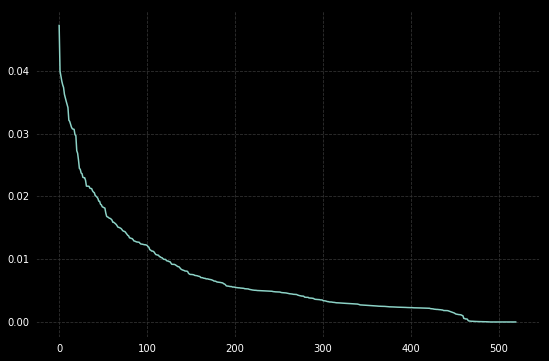

In [56]:
plt.plot(FI.sort_values(ascending=False).values)

In [75]:
ranks_sort = FI.sort_values(ascending=False)
ranks_sort = ranks_sort/ranks_sort.sum()

for i in ranks_sort.index:
    summ = ranks_sort[:i].sum()
    if summ > 0.8:
        break
selected_features = ranks_sort[:i].index

len(selected_features)

220

# Тесты на XGB и Нейронке

In [216]:
def xgb_gen():
    # ensemble из 5 облегченных xgb
    for i in np.linspace(0.1, 0.5, 5):
        yield XGBRegressor(6, i,  n_estimators=20)

In [217]:
def score_xgb(features):
    test_score = mass_fit(X[features], y['LATITUDE'], xgb_gen(), verbose=0)
    test_score = np.array([a['result'] for a in test_score]).mean()
    return test_score

In [218]:
def score_NN(features):
    X_n = X[features]
    
    m = LightNN(X_n, y, verbose=0)
    m.fit(epochs=25, batch_size=1000, need_test=False)
    m.fit(epochs=200, batch_size=5000, need_test=False)
    
    m.model.compile(optimizer=optimizers.Adam(lr=0.001, decay=0.), loss='mse', metrics=['mse'])
    m.fit(epochs=200, batch_size=X_n.shape[0])
    
    return m.result_

In [185]:
ress = res['selected_features']

In [220]:
history = []

### All features

In [221]:
features = X.columns
print(f'{"Features amount:":17}{len(features)} \n')

history.append([ score_xgb(features), score_NN(features) ])

print(f'{"XGB":17}{history[-1][0]:.6f}')
print(f'{"Neural":17}{history[-1][1]:.6f}')

Features amount: 520 

XGB              0.047070
Neural           0.009251


### Объединение match

In [222]:
features = list(set(ress[0]) & set(ress[1]) & set(ress[2]) & set(ress[3]))
print(f'{"Features amount:":17}{len(features)} \n')

history.append([ score_xgb(features), score_NN(features) ])

print(f'{"XGB":17}{history[-1][0]:.6f}')
print(f'{"Neural":17}{history[-1][1]:.6f}')

Features amount: 131 

XGB              0.061996
Neural           0.017559


### Объединение unique

In [223]:
features = list(set(ress[0]) | set(ress[1]) | set(ress[2]) | set(ress[3]))
print(f'{"Features amount:":17}{len(features)} \n')

history.append([ score_xgb(features), score_NN(features) ])

print(f'{"XGB":17}{history[-1][0]:.6f}')
print(f'{"Neural":17}{history[-1][1]:.6f}')

# 418 фич - много

Features amount: 418 

XGB              0.046997
Neural           0.007622


### Только лучший селектор

In [224]:
# (лучший для этого датасета - mutual_info)

features = ress[2]
print(f'{"Features amount:":17}{len(features)} \n')

history.append([ score_xgb(features), score_NN(features) ])

print(f'{"XGB":17}{history[-1][0]:.6f}')
print(f'{"Neural":17}{history[-1][1]:.6f}')

Features amount: 276 

XGB              0.046972
Neural           0.007035


### Объединение голосованием

In [225]:
# (фичи, за которые проголосовало 3 из 4 селектора)

votes = pd.Series(0, X.columns)
for r in ress:
    votes[r]+=1

features = votes[votes>=3].index
print(f'{"Features amount:":17}{len(features)} \n')

history.append([ score_xgb(features), score_NN(features) ])

print(f'{"XGB":17}{history[-1][0]:.6f}')
print(f'{"Neural":17}{history[-1][1]:.6f}')

Features amount: 244 

XGB              0.048313
Neural           0.007479


### Объединение взвешенным голосование

In [226]:
features = selected_features
print(f'{"Features amount:":17}{len(features)} \n')

history.append([ score_xgb(features), score_NN(features) ])

print(f'{"XGB":17}{history[-1][0]:.6f}')
print(f'{"Neural":17}{history[-1][1]:.6f}')

Features amount: 220 

XGB              0.047735
Neural           0.006480


In [244]:
names = ['raw', 'match', 'unique', 'best selector', 'vote', 'weight vote']

result_table = pd.DataFrame(history, names, columns=['XGB','Neural'])
result_table.sort_values('Neural', inplace=True)
result_table

,XGB,Neural
weight vote,0.047735,0.006480
best selector,0.046972,0.007035
vote,0.048313,0.007479
unique,0.046997,0.007622
raw,0.047070,0.009251
match,0.061996,0.017559


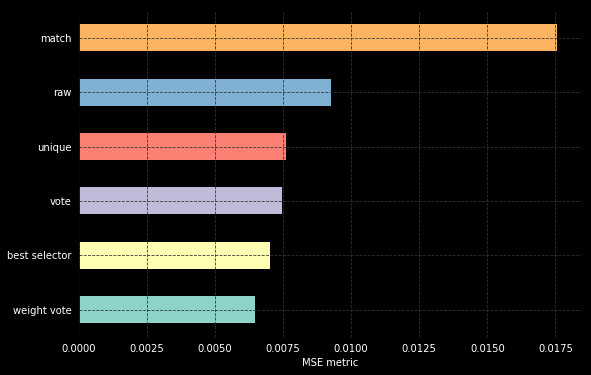

In [246]:
result_table['Neural'].plot.barh()
plt.xlabel('MSE metric');

# Тесты на Нейронке (подробные)

520
Epoch 1/25
14952/14952 [==============================] - 1s 55us/step - loss: 2.2164 - mean_squared_error: 2.2164
Epoch 2/25
14952/14952 [==============================] - 0s 8us/step - loss: 0.1994 - mean_squared_error: 0.1994
Epoch 3/25
14952/14952 [==============================] - 0s 8us/step - loss: 0.0593 - mean_squared_error: 0.0593
Epoch 4/25
14952/14952 [==============================] - 0s 9us/step - loss: 0.0312 - mean_squared_error: 0.0312
Epoch 5/25
14952/14952 [==============================] - 0s 8us/step - loss: 0.0219 - mean_squared_error: 0.0219
Epoch 6/25
14952/14952 [==============================] - 0s 8us/step - loss: 0.0184 - mean_squared_error: 0.0184
Epoch 7/25
14952/14952 [==============================] - 0s 7us/step - loss: 0.0163 - mean_squared_error: 0.0163
Epoch 8/25
14952/14952 [==============================] - 0s 7us/step - loss: 0.0148 - mean_squared_error: 0.0148
Epoch 9/25
14952/14952 [==============================] - 0s 7us/step - loss: 0.013

14952/14952 [==============================] - 0s 5us/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 117/200
14952/14952 [==============================] - 0s 6us/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 118/200
14952/14952 [==============================] - 0s 6us/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 119/200
14952/14952 [==============================] - 0s 6us/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 120/200
14952/14952 [==============================] - 0s 6us/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 121/200
14952/14952 [==============================] - 0s 5us/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 122/200
14952/14952 [==============================] - 0s 5us/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 123/200
14952/14952 [==============================] - 0s 6us/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 124/200
14952/14952 [==============================] - 0s 6us/step - los

Epoch 57/200
14952/14952 [==============================] - 0s 6us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 58/200
14952/14952 [==============================] - 0s 5us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 59/200
14952/14952 [==============================] - 0s 6us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 60/200
14952/14952 [==============================] - 0s 6us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 61/200
14952/14952 [==============================] - 0s 5us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 62/200
14952/14952 [==============================] - 0s 6us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 63/200
14952/14952 [==============================] - 0s 5us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 64/200
14952/14952 [==============================] - 0s 5us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 65/200
14952/14952 [==============================] - 0s 5us/step 

Epoch 128/200
14952/14952 [==============================] - 0s 5us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 129/200
14952/14952 [==============================] - 0s 5us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 130/200
14952/14952 [==============================] - 0s 5us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 131/200
14952/14952 [==============================] - 0s 5us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 132/200
14952/14952 [==============================] - 0s 5us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 133/200
14952/14952 [==============================] - 0s 5us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 134/200
14952/14952 [==============================] - 0s 5us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 135/200
14952/14952 [==============================] - 0s 5us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 136/200
14952/14952 [==============================] - 0s 

14952/14952 [==============================] - 0s 5us/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 199/200
14952/14952 [==============================] - 0s 5us/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 200/200
14952/14952 [==============================] - 0s 5us/step - loss: 0.0040 - mean_squared_error: 0.0040
test..

-----> 0.008492002402998241 



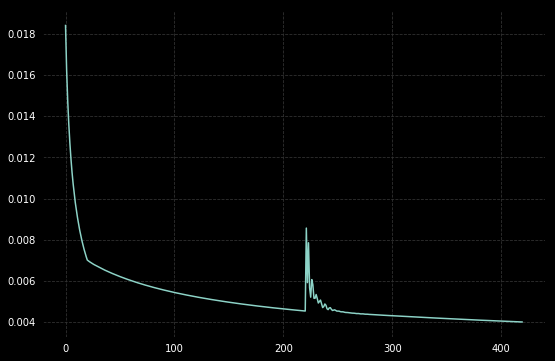

In [157]:
# raw
X_n = X

m = LightNN(X_n, y, verbose=1)
m.fit(epochs=25, batch_size=1000)
m.fit(epochs=200, batch_size=5000)
m.model.compile(optimizer=optimizers.Adam(lr=0.001, decay=0.), loss='mse', metrics=['mse'])
m.fit(epochs=200, batch_size=X_n.shape[0])

plt.plot(m.full_hist_loss[5:])

276
Epoch 1/25
14952/14952 [==============================] - 1s 49us/step - loss: 1.6297 - mean_squared_error: 1.6297
Epoch 2/25
14952/14952 [==============================] - 0s 5us/step - loss: 0.1550 - mean_squared_error: 0.1550
Epoch 3/25
14952/14952 [==============================] - 0s 6us/step - loss: 0.0579 - mean_squared_error: 0.0579
Epoch 4/25
14952/14952 [==============================] - 0s 5us/step - loss: 0.0281 - mean_squared_error: 0.0281
Epoch 5/25
14952/14952 [==============================] - 0s 5us/step - loss: 0.0204 - mean_squared_error: 0.0204
Epoch 6/25
14952/14952 [==============================] - 0s 5us/step - loss: 0.0170 - mean_squared_error: 0.0170
Epoch 7/25
14952/14952 [==============================] - 0s 7us/step - loss: 0.0151 - mean_squared_error: 0.0151
Epoch 8/25
14952/14952 [==============================] - 0s 6us/step - loss: 0.0137 - mean_squared_error: 0.0137
Epoch 9/25
14952/14952 [==============================] - 0s 6us/step - loss: 0.012

14952/14952 [==============================] - 0s 4us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 117/200
14952/14952 [==============================] - 0s 4us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 118/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 119/200
14952/14952 [==============================] - 0s 4us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 120/200
14952/14952 [==============================] - 0s 4us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 121/200
14952/14952 [==============================] - 0s 4us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 122/200
14952/14952 [==============================] - 0s 4us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 123/200
14952/14952 [==============================] - 0s 4us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 124/200
14952/14952 [==============================] - 0s 4us/step - los

Epoch 57/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 58/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 59/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 60/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 61/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 62/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 63/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 64/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 65/200
14952/14952 [==============================] - 0s 3us/step 

Epoch 128/200
14952/14952 [==============================] - 0s 4us/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 129/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 130/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 131/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 132/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 133/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 134/200
14952/14952 [==============================] - 0s 4us/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 135/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 136/200
14952/14952 [==============================] - 0s 

14952/14952 [==============================] - 0s 3us/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 199/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 200/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0039 - mean_squared_error: 0.0039
test..

-----> 0.0076297139671559645 



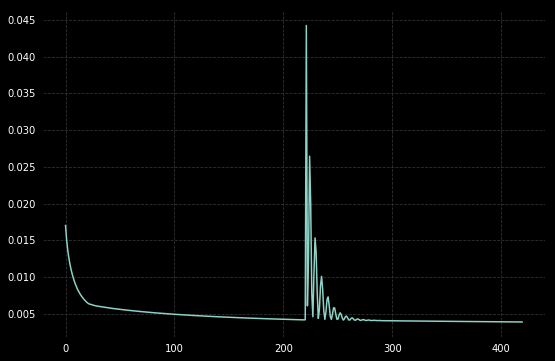

In [156]:
# best selector
X_n = X[ress[2]]

m = LightNN(X_n, y, verbose=1)
m.fit(epochs=25, batch_size=1000)
m.fit(epochs=200, batch_size=5000)
m.model.compile(optimizer=optimizers.Adam(lr=0.001, decay=0.), loss='mse', metrics=['mse'])
m.fit(epochs=200, batch_size=X_n.shape[0])

plt.plot(m.full_hist_loss[5:])

244
Epoch 1/25
14952/14952 [==============================] - 1s 43us/step - loss: 1.2534 - mean_squared_error: 1.2534
Epoch 2/25
14952/14952 [==============================] - 0s 5us/step - loss: 0.1510 - mean_squared_error: 0.1510
Epoch 3/25
14952/14952 [==============================] - 0s 5us/step - loss: 0.0477 - mean_squared_error: 0.0477
Epoch 4/25
14952/14952 [==============================] - 0s 5us/step - loss: 0.0270 - mean_squared_error: 0.0270
Epoch 5/25
14952/14952 [==============================] - 0s 5us/step - loss: 0.0206 - mean_squared_error: 0.0206
Epoch 6/25
14952/14952 [==============================] - 0s 6us/step - loss: 0.0177 - mean_squared_error: 0.0177
Epoch 7/25
14952/14952 [==============================] - 0s 6us/step - loss: 0.0160 - mean_squared_error: 0.0160
Epoch 8/25
14952/14952 [==============================] - 0s 6us/step - loss: 0.0147 - mean_squared_error: 0.0147
Epoch 9/25
14952/14952 [==============================] - 0s 5us/step - loss: 0.013

14952/14952 [==============================] - 0s 3us/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 117/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 118/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 119/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 120/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 121/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 122/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 123/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 124/200
14952/14952 [==============================] - 0s 3us/step - los

Epoch 57/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 58/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 59/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 60/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 61/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 62/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 63/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 64/200
14952/14952 [==============================] - 0s 2us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 65/200
14952/14952 [==============================] - 0s 3us/step 

Epoch 128/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 129/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 130/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 131/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 132/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 133/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 134/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 135/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 136/200
14952/14952 [==============================] - 0s 

14952/14952 [==============================] - 0s 3us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 199/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 200/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0041 - mean_squared_error: 0.0041
test..

-----> 0.00823438650949811 



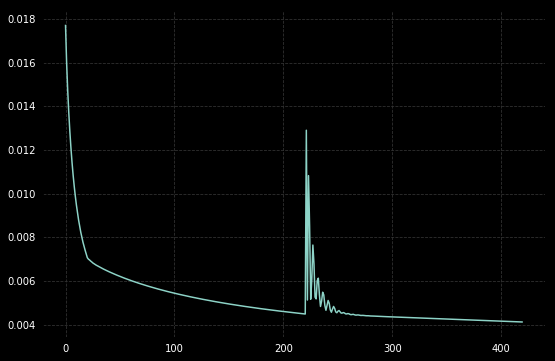

In [154]:
# vote
X_n = X[votes[votes>=3].index]

m = LightNN(X_n, y, verbose=1)
m.fit(epochs=25, batch_size=1000)
m.fit(epochs=200, batch_size=5000)
m.model.compile(optimizer=optimizers.Adam(lr=0.001, decay=0.), loss='mse', metrics=['mse'])
m.fit(epochs=200, batch_size=X_n.shape[0])

plt.plot(m.full_hist_loss[5:])

220
Epoch 1/25
14952/14952 [==============================] - 1s 45us/step - loss: 1.4060 - mean_squared_error: 1.4060
Epoch 2/25
14952/14952 [==============================] - 0s 5us/step - loss: 0.1722 - mean_squared_error: 0.1722
Epoch 3/25
14952/14952 [==============================] - 0s 5us/step - loss: 0.0555 - mean_squared_error: 0.0555
Epoch 4/25
14952/14952 [==============================] - 0s 5us/step - loss: 0.0283 - mean_squared_error: 0.0283
Epoch 5/25
14952/14952 [==============================] - 0s 5us/step - loss: 0.0204 - mean_squared_error: 0.0204
Epoch 6/25
14952/14952 [==============================] - 0s 5us/step - loss: 0.0172 - mean_squared_error: 0.0172
Epoch 7/25
14952/14952 [==============================] - 0s 5us/step - loss: 0.0154 - mean_squared_error: 0.0154
Epoch 8/25
14952/14952 [==============================] - 0s 5us/step - loss: 0.0142 - mean_squared_error: 0.0142
Epoch 9/25
14952/14952 [==============================] - 0s 5us/step - loss: 0.013

14952/14952 [==============================] - 0s 4us/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 117/200
14952/14952 [==============================] - 0s 4us/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 118/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 119/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 120/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 121/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 122/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 123/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 124/200
14952/14952 [==============================] - 0s 3us/step - los

Epoch 57/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 58/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 59/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 60/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 61/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 62/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 63/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 64/200
14952/14952 [==============================] - 0s 2us/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 65/200
14952/14952 [==============================] - 0s 2us/step 

Epoch 128/200
14952/14952 [==============================] - 0s 2us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 129/200
14952/14952 [==============================] - 0s 2us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 130/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 131/200
14952/14952 [==============================] - 0s 2us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 132/200
14952/14952 [==============================] - 0s 2us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 133/200
14952/14952 [==============================] - 0s 2us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 134/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 135/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 136/200
14952/14952 [==============================] - 0s 

14952/14952 [==============================] - 0s 3us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 199/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 200/200
14952/14952 [==============================] - 0s 3us/step - loss: 0.0043 - mean_squared_error: 0.0043
load..
test..

-----> 0.006468706335478089 



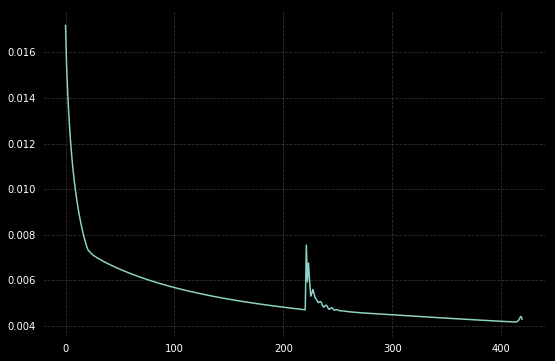

In [155]:
# weight vote
X_n = X[selected_features]

m = LightNN(X_n, y, verbose=1)
m.fit(epochs=25, batch_size=1000)
m.fit(epochs=200, batch_size=5000)
m.model.compile(optimizer=optimizers.Adam(lr=0.001, decay=0.), loss='mse', metrics=['mse'])
m.fit(epochs=200, batch_size=X_n.shape[0])

plt.plot(m.full_hist_loss[5:])